In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plutils import general

In [2]:
MINE = '/net/topmed10/working/porchard/rnaseq/work/test-crossmap/results/snp-mappability/snp_mappability_75mer_2mismatch.bed.gz'
THEIRS = '/net/topmed10/working/porchard/rnaseq/data/mappability/hg38_snp_mappability_75mer.bed.bgz'

In [3]:
# examine chr21
WINDOW = 'chr21:1-9999999999999'
mine = general.tabix(MINE, WINDOW)
mine.columns = ['chrom', 'start', 'end', 'score']
for i in ['score']:
    mine[i] = mine[i].astype(float)
for i in ['start', 'end']:
    mine[i] = mine[i].astype(int)
mine.head()

,chrom,start,end,score
0,chr21,0,1,0.0
1,chr21,1,2,0.0
2,chr21,2,3,0.0
3,chr21,3,4,0.0
4,chr21,4,5,0.0


In [4]:
theirs = general.tabix(THEIRS, WINDOW)
theirs.columns = ['chrom', 'start', 'end', 'score']
for i in ['score']:
    theirs[i] = theirs[i].astype(float)
for i in ['start', 'end']:
    theirs[i] = theirs[i].astype(int)
theirs.head()

,chrom,start,end,score
0,chr21,0,5010002,0.000000
1,chr21,5010002,5010003,0.006667
2,chr21,5010003,5010004,0.013333
3,chr21,5010004,5010005,0.020000
4,chr21,5010005,5010006,0.026667


In [5]:
# expand their scores
# pos --> score
their_scores = dict()
for start, end, score in zip(theirs.start, theirs.end, theirs.score):
    for pos in range(start+1, end+1):
        their_scores[pos] = score

In [6]:
comb = mine.rename(columns={'score': 'mine'})
comb['theirs'] = comb.end.map(their_scores)
comb.head()

,chrom,start,end,mine,theirs
0,chr21,0,1,0.0,0.0
1,chr21,1,2,0.0,0.0
2,chr21,2,3,0.0,0.0
3,chr21,3,4,0.0,0.0
4,chr21,4,5,0.0,0.0


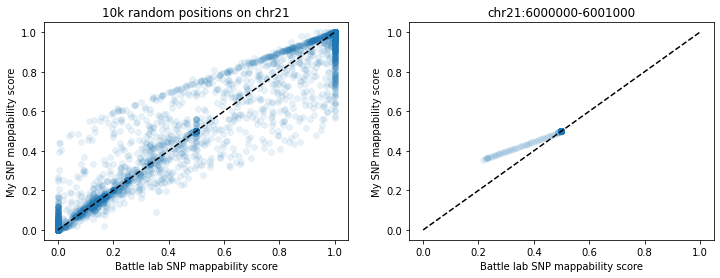

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(6*2, 4))

ax = axs[0]
ax.set_title('10k random positions on chr21')
sns.scatterplot(x='theirs', y='mine', data=comb.sample(10000), ax=ax, edgecolor=None, alpha=0.1)
ax.set_xlabel('Battle lab SNP mappability score')
ax.set_ylabel('My SNP mappability score')
ax.plot([0, 1], [0, 1], ls='--', color='black')

ax = axs[1]
ax.set_title('chr21:6000000-6001000')
sns.scatterplot(x='theirs', y='mine', data=comb[(comb.end>6000000) & (comb.end<=6001000)], ax=ax, edgecolor=None, alpha=0.1)
ax.set_xlabel('Battle lab SNP mappability score')
ax.set_ylabel('My SNP mappability score')
ax.plot([0, 1], [0, 1], ls='--', color='black')

In [8]:
# if I say it's mappability is ~0, they do as well
# if I say it's mappability is 1, they do as well
# if they say it's mappability is 0, I might say it's somewhat mappable
# if they say it's mappability is 1, I might say it's not necessarily

# this indicates they're only actually using a subset of kmers that I'm using to define the mappability

In [9]:
# try to sort out the difference
KMER_MAPPABILITY = '/net/topmed10/working/porchard/rnaseq/work/test-crossmap/work/60/ea9a1e7f64ba860c7616ddf035ddc4/out/mappability_75mer_2mismatch.bed'
K = 75
SPAN = (K * 2) - 1


class ChunkedFileReader:

    def __init__(self, fh, field):
        assert(isinstance(field, int))
        self.fh = fh
        self.field = field
        self.current_value = None
        self.next_set = []
        self.eof = False


    def __next__(self):
        # read until eof or until the field changes
        lines = self.next_set.copy()
        self.next_set = []
        if self.eof:
            raise StopIteration

        while True:
            line = self.fh.readline()
            if line == '':
                self.eof = True
                return lines
            line = line.rstrip()
            new_value = line.split()[self.field]
            if self.current_value is None or new_value == self.current_value:
                self.current_value = new_value
                lines.append(line)
            else:
                self.next_set.append(line)
                self.current_value = new_value
                return lines

    def __iter__(self):
        return self




with open(KMER_MAPPABILITY, 'r') as fh:
    for chunk in ChunkedFileReader(fh, 0):
        chrom = chunk[0].split('\t')[0]
        if chrom == 'chr21':
            break

pos = []
value = []
for i in chunk:
    chrom, start, end, score = i.split('\t')
    start, end, score = int(start), int(end), float(score)
    for p in range(start, end):
        pos.append(p)
        value.append(score)
chr_series = pd.Series(value, index=pos)
what_i_think_they_did = chr_series.rolling(K, min_periods=0, center=False).mean()
comb['what_i_think_they_did'] = what_i_think_they_did

In [10]:
comb[comb.theirs>0].head()

,chrom,start,end,mine,theirs,what_i_think_they_did
5010002,chr21,5010002,5010003,0.250000,0.006667,0.006667
5010003,chr21,5010003,5010004,0.253333,0.013333,0.013333
5010004,chr21,5010004,5010005,0.256667,0.020000,0.020000
5010005,chr21,5010005,5010006,0.260000,0.026667,0.026667
5010006,chr21,5010006,5010007,0.263333,0.033333,0.033333


<AxesSubplot:title={'center':'Histogram of differences over chr21'}>

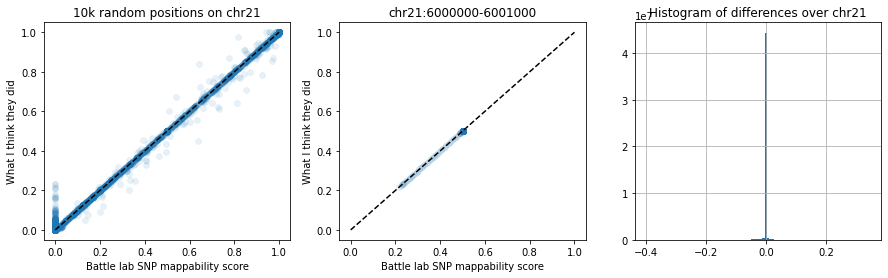

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(5*3, 4))

ax = axs[0]
ax.set_title('10k random positions on chr21')
sns.scatterplot(x='theirs', y='what_i_think_they_did', data=comb.sample(10000), ax=ax, edgecolor=None, alpha=0.1)
ax.set_xlabel('Battle lab SNP mappability score')
ax.set_ylabel('What I think they did')
ax.plot([0, 1], [0, 1], ls='--', color='black')

ax = axs[1]
ax.set_title('chr21:6000000-6001000')
sns.scatterplot(x='theirs', y='what_i_think_they_did', data=comb[(comb.end>6000000) & (comb.end<=6001000)], ax=ax, edgecolor=None, alpha=0.1)
ax.set_xlabel('Battle lab SNP mappability score')
ax.set_ylabel('What I think they did')
ax.plot([0, 1], [0, 1], ls='--', color='black')


ax = axs[2]
ax.set_title('Histogram of differences over chr21')
(comb.theirs - comb.what_i_think_they_did).hist(bins=100, ax=ax)
